In [ ]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.layers import Activation, Dense
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Merge
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

In [2]:
TRAIN_CSV = '../dataset/train.txt'
TEST_CSV = '../dataset/test.txt'
EMBEDDING_FILE = '../models/GoogleNews-vectors-negative300.bin'
MODEL_SAVING_DIR = '../models/'

In [ ]:
# Load training and test set
train_df = pd.read_csv(TRAIN_CSV, sep="\t", error_bad_lines=False)
test_df = pd.read_csv(TEST_CSV, sep="\t", error_bad_lines=False)

train_df = train_df.rename(columns={'#1 String': 'sentence1', '#2 String': 'sentence2'})
test_df = test_df.rename(columns={'#1 String': 'sentence1', '#2 String': 'sentence2'})

stops = set(stopwords.words('english'))

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

# Prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

sentence_cols = ['sentence1', 'sentence2']

# Iterate over the questions only of both training and test datasets
for dataset in [train_df, test_df]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for sentence in sentence_cols:

            s2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[sentence]):

                # Check for unwanted words
                if word in stops and word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    s2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    s2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.set_value(index, sentence, s2n)
            
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

del word2vec

In [36]:
# determining maximum length of sentence
max_seq_length = max(train_df.sentence1.map(lambda x: len(x)).max(),
                     train_df.sentence2.map(lambda x: len(x)).max(),
                     test_df.sentence1.map(lambda x: len(x)).max(),
                     test_df.sentence2.map(lambda x: len(x)).max())

# Split to train validation
validation_size = 600
training_size = len(train_df) - validation_size

X = train_df[sentence_cols]
Y = train_df['Quality']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

# Split to dicts
X_train = {'left': X_train.sentence1, 'right': X_train.sentence2}
X_test = {'left': test_df.sentence1, 'right': test_df.sentence2}
X_validation = {'left': X_validation.sentence1, 'right': X_validation.sentence2}

Y_test = test_df['Quality']

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_test = Y_test.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_test, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [37]:
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

In [38]:
print(X_train['left'].shape)

(3338, 419)


In [39]:
#Convolution for siamese network
from keras.layers import Conv1D, MaxPooling1D
l_conv_shared = Conv1D(128, 5, activation='relu')

left_conv = l_conv_shared(encoded_left)
right_conv = l_conv_shared(encoded_right)

In [40]:
# Max Pooling for siamese network
l_pool_shared = MaxPooling1D(5)

left_pool = l_pool_shared(left_conv)
right_pool = l_pool_shared(right_conv)

In [41]:
# Since this is a siamese network, both share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(left_pool)
right_output = shared_lstm(right_pool)

In [ ]:
# Calculates the distance as defined by the MaLSTM model
malstm_distance = Merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

#Adding Dense layers and sigmoid activation
#malstm.add(Dense(64))
#malstm.add(Dense(64))
#malstm.add(Activation('sigmoid'))

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Start training
training_start_time = time()

#validation_data=([X_test['left'], X_test['right']], Y_test)
malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, epochs=5, validation_data=([X_validation['left'], X_validation['right']], Y_validation))


print("Training time finished.\n{} epochs in {}".format(5, datetime.timedelta(seconds=time()-training_start_time)))

In [ ]:
malstm_tested = malstm.evaluate([X_test['left'], X_test['right']], Y_test, verbose=1)
print(malstm_tested)

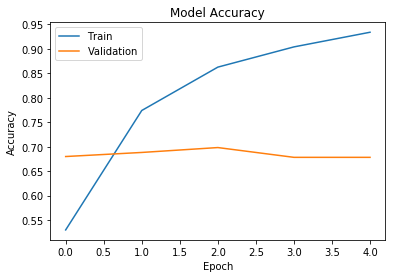

In [46]:
# Plot accuracy
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.show()
plt.savefig('EpochVsAccuracy')

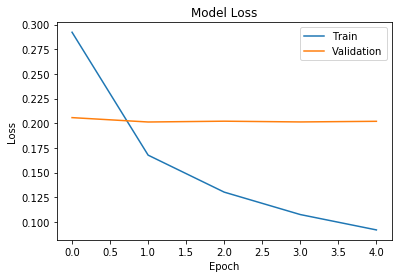

In [47]:
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.savefig('EpochVsLoss')